# Analytic element modeling of steady two-dimensional flow 

The Python code provided below is derived from Chapter 8 edited by Christina Norton <br>
**Analytical Groundwater Modeling: Theory and Applications Using Python** <br>
by *Mark Bakker and Vincent Post* <br>
ISBN 9781138029392   <br>
The book is published by CRC press and is available [here](https://www.routledge.com/Analytical-Groundwater-Modeling-Theory-and-Applications-using-Python/Bakker-Post/p/book/9781138029392).  <br>
This Notebook is provided under the [MIT license](https://github.com/pythongroundwaterbook/analytic_gw_book/blob/main/LICENSE). <br>
© 2022 Mark Bakker and Vincent Post

In [31]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 3) # set default figure size
plt.rcParams["contour.negative_linestyle"] = 'solid' # set default line style
plt.rcParams["figure.autolayout"] = True # same at tight_layout after every plot

## Uniform flow and wells

In [32]:
class Model:
    
    def __init__(self, T):
        self.T = T
        self.elements = [] # list of all elements
        
    def omega(self, x, y):
        omega = 0 + 0j
        for e in self.elements:
            omega += e.omega(x, y)
        return omega
    
    def potential(self, x, y):
        return self.omega(x, y).real
    
    def streamfunction(self, x, y):
        return self.omega(x, y).imag
        
    def head(self, x, y):
        return self.potential(x, y) / self.T
    
    def solve(self):
        esolve = [e for e in self.elements if e.nunknowns == 1]
        nunknowns = len(esolve)
        matrix = np.zeros((nunknowns, nunknowns))
        rhs = np.zeros(nunknowns)
        for irow in range(nunknowns):
            matrix[irow], rhs[irow] = esolve[irow].equation()
        solution = np.linalg.solve(matrix, rhs)
        for irow in range(nunknowns):
            esolve[irow].parameter = solution[irow]

In [33]:
class Element:
    
    def __init__(self, model, p):
        self.model = model
        self.parameter = p
        self.nunknowns = 0
        self.model.elements.append(self)
        
    def omega(self, x, y):
        return self.parameter * self.omegainf(x, y)
    
    def potential(self, x, y):
        return self.omega(x, y).real
    
    def potinf(self, x, y):
        return self.omegainf(x, y).real

In [34]:
class Well(Element):
    
    def __init__(self, model, xw=0, yw=0, Q=1, rw=0.3):
        Element.__init__(self, model, p=Q)
        self.zetaw = xw + 1j * yw
        self.rw = rw
            
    def omegainf(self, x, y):
        zminzw = x + 1j * y - self.zetaw
        zminzw = np.where(np.abs(zminzw) < self.rw, self.rw, zminzw)
        return 1 / (2 * np.pi) * np.log(zminzw)

In [35]:
class UniformFlow(Element):
    
    def __init__(self, model, gradient, angle):
        Element.__init__(self, model, p=model.T * gradient)
        self.udir = np.exp(-1j * np.deg2rad(angle))
        
    def omegainf(self, x, y):
        return -self.udir * (x + y * 1j)

In [42]:
# parameters and model
ml = Model(T=100) # transmissivity, m^2/d
Well(ml, xw=50, yw=40, Q=200) # extraction well, Q in m^3/d
Well(ml, xw=-50, yw=50, Q=100) # extraction well, Q in m^3/d
Well(ml, xw=0, yw=0, Q=-300) # injection well, Q in m^3/d
UniformFlow(ml, gradient=0.002, angle=-45);

In [43]:
# solution
xg, yg = np.meshgrid(np.linspace(-100, 100, 100), np.linspace(-75, 75, 100))
pot = ml.potential(xg, yg)
psi = ml.streamfunction(xg, yg)

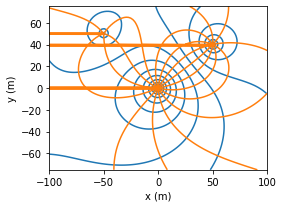

In [44]:
# basic flow net
plt.subplot(111, aspect=1)
plt.contour(xg, yg, pot, 20, colors='C0')
plt.contour(xg, yg, psi, 20, colors='C1')
plt.xlabel('x (m)')
plt.ylabel('y (m)');

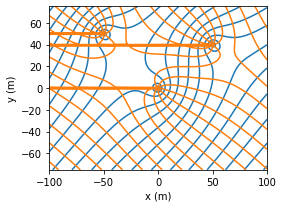

In [49]:
# parameters and model
ml = Model(T=100) # transmissivity, m^2/d
Well(ml, xw=50, yw=40, Q=20) # extraction well, Q in m^3/d
Well(ml, xw=-50, yw=50, Q=20) # extraction well, Q in m^3/d
Well(ml, xw=0, yw=0, Q=-20) # injection well, Q in m^3/d
UniformFlow(ml, gradient=0.002, angle=-45);
# solution
xg, yg = np.meshgrid(np.linspace(-100, 100, 100), np.linspace(-75, 75, 100))
pot = ml.potential(xg, yg)
psi = ml.streamfunction(xg, yg)
# basic flow net
plt.subplot(111, aspect=1)
plt.contour(xg, yg, pot, 20, colors='C0')
plt.contour(xg, yg, psi, 20, colors='C1')
plt.xlabel('x (m)')
plt.ylabel('y (m)');

In [50]:
class HeadEquation:

    def equation(self):
        row = []
        rhs = self.pc
        for e in self.model.elements:
            if e.nunknowns == 1:
                row.append(e.potinf(self.xc, self.yc))
            else:
                rhs -= e.potential(self.xc, self.yc)
        return row, rhs

In [51]:
class HeadWell(Well, HeadEquation):
    
    def __init__(self, model, xw, yw, rw, hw):
        Well.__init__(self, model, xw, yw, 0, rw)
        self.xc, self.yc = xw + rw, yw
        self.pc = self.model.T * hw
        self.nunknowns = 1

In [52]:
class Constant(Element, HeadEquation):
    
    def __init__(self, model, xc, yc, hc):
        Element.__init__(self, model, p=0)
        self.xc, self.yc = xc, yc
        self.pc = self.model.T * hc
        self.nunknowns = 1
        
    def omegainf(self, x, y):
        return np.ones_like(x, dtype='complex')

In [53]:
# parameters and model
ml = Model(T=100) # transmissivity in m^2/d
w1 = Well(ml, xw=0, yw=0, Q=-100, rw=0.3) # Q in m^3/d
w2 = HeadWell(ml, xw=400, yw=300, rw=0.3, hw=20)
w3 = HeadWell(ml, xw=100, yw=400, rw=0.3, hw=20)
uf = UniformFlow(ml, gradient=0.002, angle=0)
rf = Constant(ml, xc=400, yc=0, hc=22)

In [54]:
# solution
ml.solve() # compute the unkown parameters

print(f'computed head at discharge-specified well: {ml.head(0, 0):.2f} m')
print(f'computed head at head-specified well: {ml.head(400.3, 300):.2f} m')
print(f'computed discharge of head-specified well 2: {w2.parameter:.2f} m^3/d')
print(f'computed discharge of head-specified well 3: {w3.parameter:.2f} m^3/d')
print(f'computed head at reference point: {ml.head(400, 0):.2f} m')
# grid
xg, yg = np.meshgrid(np.linspace(-200, 600, 100), np.linspace(-100, 500, 100))
head = ml.head(xg, yg)
psi = ml.streamfunction(xg, yg)
print(f'min and max head on grid: {head.min():.2f}, {head.max():.2f}')
print(f'min and max psi on grid: {psi.min():.2f}, {psi.max():.2f}')

computed head at discharge-specified well: 24.01 m
computed head at head-specified well: 20.00 m
computed discharge of head-specified well 2: 164.00 m^3/d
computed discharge of head-specified well 3: 220.89 m^3/d
computed head at reference point: 22.00 m
min and max head on grid: 20.50, 23.61
min and max psi on grid: -273.53, 79.41


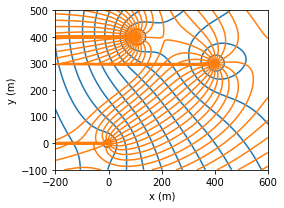

In [55]:
# basic flow net (right graph)
plt.subplot(111, aspect=1)
plt.contour(xg, yg, head, np.arange(20, 24, 0.2), colors='C0')
Q = w2.parameter # used to set stream function contour interval
plt.contour(xg, yg, psi, np.arange(-200, 100, Q / 20), colors='C1')
plt.xlabel('x (m)')
plt.ylabel('y (m)');